## Deramping radar
This example shows how to use a Kalman filter to estimate range and range rate from a raw radar measurement

In [1]:
from datetime import datetime, timezone

import numpy as np
from numpy import pi

from blocksim.control.Estimator import (
    TimeInvariantKalmanFilter,
    SteadyStateKalmanFilter,
)
from blocksim.satellite.Satellite import CircleSatellite
from blocksim.control.SetPoint import Step
from blocksim.constants import c, Req
from blocksim.utils import azeld_to_itrf, itrf_to_azeld
from blocksim.Simulation import Simulation
from blocksim.core.Node import AComputer, AWGNOutput
from blocksim.graphics import plotFromLogger
from blocksim.graphics.BFigure import FigureFactory

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.XlsLogger


## Setup configuration
We first define a radar, that takes as input the real range and range rate. As output, it derives a noisy beat tone.

In [2]:
class Radar(AComputer):
    def __init__(self, name: str, B: float, T: float, wl: float):
        super().__init__(name=name)
        self.defineInput("rec", shape=(6,), dtype=np.float64)
        self.defineInput("sat", shape=(6,), dtype=np.float64)
        self.defineOutput(name="dv", snames=["d", "v"], dtype=np.float64)

        otp = AWGNOutput(name="fb", snames=["fb"], dtype=np.float64)
        otp.cov = np.eye(1) / T**2
        otp.mean = np.zeros(1)
        self.addOutput(otp)

        self.createParameter(name="bandwidth", value=B)
        self.createParameter(name="tau", value=T)
        self.createParameter(name="wavelength", value=wl)

    def update(self, t1: float, t2: float, **inputs: dict) -> dict:
        obs = inputs["rec"]
        sat = inputs["sat"]
        az, el, dist, azr, elr, vr = itrf_to_azeld(obs, sat)

        fb = 2 * self.bandwidth / (self.tau * c) * dist + 1 / self.wavelength * vr

        outputs = {}
        outputs["dv"] = np.array([dist, vr])
        outputs["fb"] = np.array([fb])

        return outputs

Then we define a Kalman estimator of range and range rate. The command will be a null step.

In [3]:
class DVEstimator(SteadyStateKalmanFilter):
    def __init__(self, name: str, B: float, T: float, wl: float, dt: float):
        super().__init__(
            name=name,
            shape_cmd=(1,),
            snames_state=["d", "v"],
            snames_output=["fb"],
            dt=dt,
        )
        self.matA = np.array([[0, 1], [0, 0]], dtype=np.float64)
        self.matB = np.array([[0, 0]], dtype=np.float64).T
        self.matC = np.array([[2 * B / (T * c), 1 / wl]])
        self.matD = np.array([[0]])
        self.matQ = np.diag([c / (2 * B), wl / 2 / T]) ** 2
        self.matR = np.eye(1) / T**2

        self.createParameter(name="bandwidth", value=B)
        self.createParameter(name="tau", value=T)
        self.createParameter(name="wavelength", value=wl)

In [4]:
cmd = Step(name="cmd", snames=["u"], cons=np.array([0]))

The radar, located at the surface of Earth, observes a satellite

In [5]:
pv_obs = np.array([Req, 0, 0, 0, 0, 0])
rec = Step(name="rec", snames=["px", "py", "pz", "vx", "vy", "vz"], cons=pv_obs)

In [6]:
t0 = datetime(
    year=2022, month=5, day=24, hour=13, minute=0, second=0, tzinfo=timezone.utc
)
pv = azeld_to_itrf(azeld=(pi / 2, pi / 4, 1000e3, 1, 0, -pi / 2), obs=pv_obs)
sat = CircleSatellite.fromITRF(name="sat", tsync=t0, pv_itrf=pv)

We instanciate the Kalman filter and the radar

In [7]:
B = 1.5e9
T = 4e-3
wl = c / 24.75e9
dt = T

kal = DVEstimator("kal", B, T, wl, dt)

rad = Radar("rad", B, T, wl)

## Simulation

In [8]:
sim = Simulation(cmd, rad, kal, rec, sat)
sim.connect("rec.setpoint", "rad.rec")
sim.connect("sat.itrf", "rad.sat")
sim.connect("rad.fb", "kal.measurement")
sim.connect("cmd.setpoint", "kal.command")

In [9]:
ns = int(10 / dt)
tps = np.arange(ns) * dt

sim.simulate(tps, progress_bar=False)
log = sim.getLogger()

## Plotting

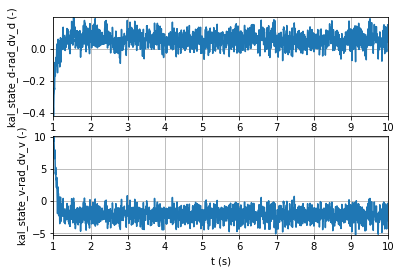

In [11]:
fig = FigureFactory.create()
gs = fig.add_gridspec(2, 1)
axe = fig.add_baxe(title="", spec=gs[0, 0])
line = plotFromLogger(
    log, id_x="t", id_y="kal_state_d-rad_dv_d", axe=axe, label="kal-rad"
)
# axe.set_ylim(-0.3, 0.3)

axe = fig.add_baxe(title="", spec=gs[1, 0], sharex=axe)
line = plotFromLogger(
    log,
    id_x="t",
    id_y="kal_state_v-rad_dv_v",
    axe=axe,
    label="kal-rad",
)
# axe.set_ylim(-7.5, 7.5)
axe.set_xlim(1, 10)

mfig = fig.render()